<a href="https://colab.research.google.com/github/ujjawalcse/My-ML-Project/blob/master/Tensorflow_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ujjawalcse/models.git

Cloning into 'models'...
remote: Enumerating objects: 24837, done.
remote: Total 24837 (delta 0), reused 0 (delta 0), pack-reused 24837
Receiving objects: 100% (24837/24837), 507.54 MiB | 29.27 MiB/s, done.
Resolving deltas: 100% (14765/14765), done.
Checking out files: 100% (2862/2862), done.


In [0]:
import os
import cv2
import time
import argparse
import multiprocessing
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
cd models/research

/content/models/research


In [4]:
!git clone https://github.com/cocodataset/cocoapi.git

Cloning into 'cocoapi'...
remote: Enumerating objects: 953, done.
remote: Total 953 (delta 0), reused 0 (delta 0), pack-reused 953
Receiving objects: 100% (953/953), 11.70 MiB | 27.23 MiB/s, done.
Resolving deltas: 100% (566/566), done.


In [5]:
!pwd

/content/models/research


In [0]:
!protoc object_detection/protos/*.proto --python_out=.

In [0]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
current_directory=os.getcwd()

#Path to the frozen inference graph
model_name='ssd_mobilenet_v1_coco_11_06_2017'    
checkpoint_path=os.path.join(current_directory,'object_detection','frozen_inference_graph.pb')

#Path to the labels that is used to add correct label for each box
labels_path=os.path.join(current_directory,'object_detection','data','mscoco_label_map.pbtxt')

In [0]:
# Since the model is trained on COCO dataset that has 90 different classes,so num_classes=90
NUM_CLASSES = 90

# Loading label map
label_map = label_map_util.load_labelmap(labels_path)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES,
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [0]:
def detect_objects(image_as_array,sess,detection_graph):
  #Since the model expect shape as [1, None, None, 3],so we have to expand dimension of the image
  image_expanded=np.expand_dims(image_as_array,axis=0)
  image_tensor=detection_graph.get_tensor_by_name('image_tensor:0')
  
  #Each box represent the detected object
  boxes=detection_graph.get_tensor_by_name('detection_boxes:0')
  
  #Scores corresponding to each box represent the confidence level 
  scores=detection_graph.get_tensor_by_name('detection_scores:0')
  classes = detection_graph.get_tensor_by_name('detection_classes:0')
  num_detections = detection_graph.get_tensor_by_name('num_detections:0')
  
  #Detection session goes here
  (boxes,scores,classes,num_detections)=sess.run([boxes,scores,classes,num_detections],feed_dict={image_tensor: image_expanded})
  
  #Visualisation of object detection result
  vis_util.visualize_boxes_and_labels_on_image_array(
        image_as_array,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8)
  return image_as_array

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


In [13]:
#Executed twice to move from /content/models/research to /content
cd ..

/content


In [0]:
#This will move my frozen_inference_graph.pb from /content folder to /content/models/research/object_detection
!bash -c 'mv frozen_inference_graph.pb /content/models/research/object_detection'


In [15]:
#Now going back to our working directory
cd models/research

/content/models/research


In [0]:
#Load frozen TF model in memory so that we can use it here
detection_graph=tf.Graph()
with detection_graph.as_default():
  od_graph_def=tf.GraphDef()
  with tf.gfile.GFile(checkpoint_path,'rb') as fid:
    serialized_graph=fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

(636, 1024, 3)


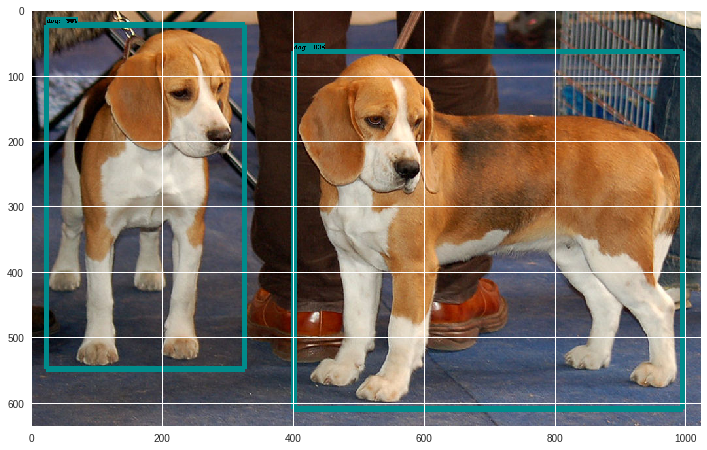

(900, 1352, 3)


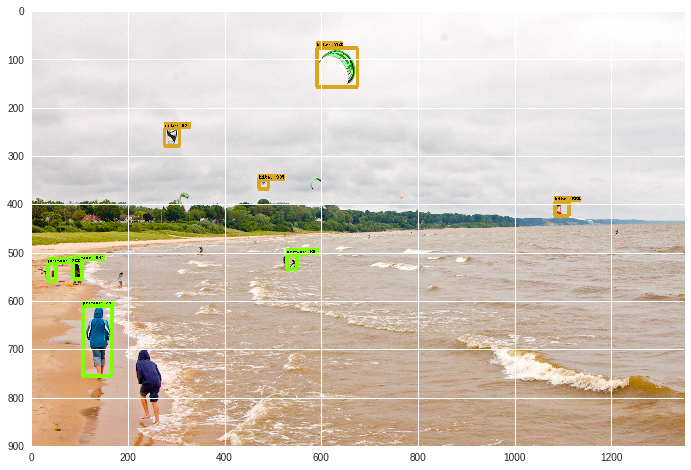

In [21]:
# Working object detection on test images
%matplotlib inline
from PIL import Image
PATH_TO_TEST_IMAGES_DIR = 'object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]
IMAGE_SIZE = (12, 8)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            image_process = detect_objects(image_np, sess, detection_graph)
            print(image_process.shape)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_process)
            plt.show()

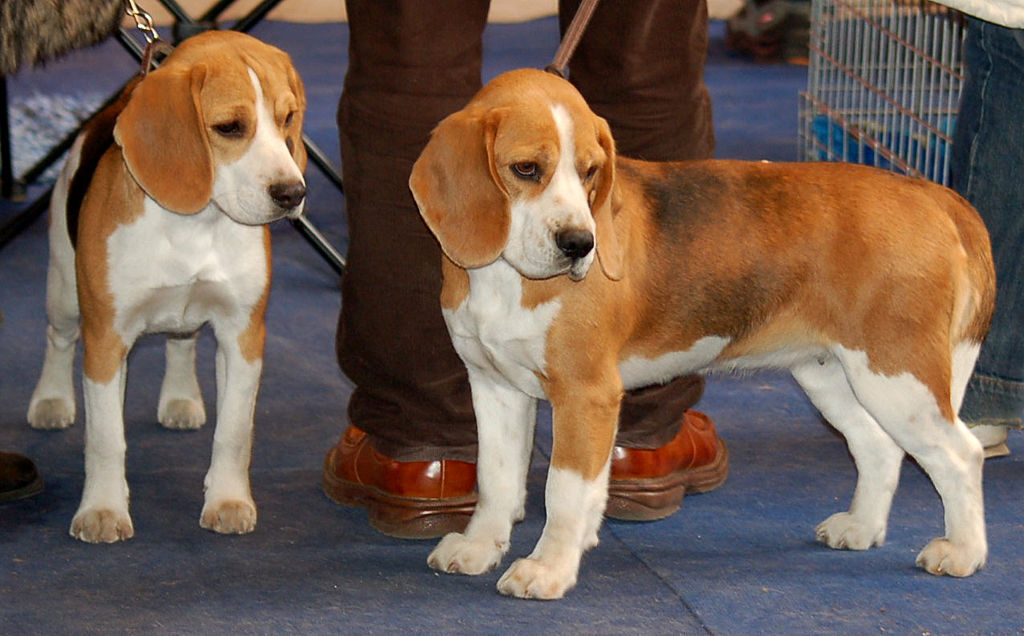

In [0]:
#Just for checking purpose, since cv2.imshow() is incompatible for this jupyter notebook ,so there is a replacement as cv_imshow()
img=cv2.imread('object_detection/test_images/image1.jpg')
cv2_imshow(img)

In [0]:
#This and below code cell is added from  Camera Capture section of the google colab Code Snippets for using webcam to capture photo 
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


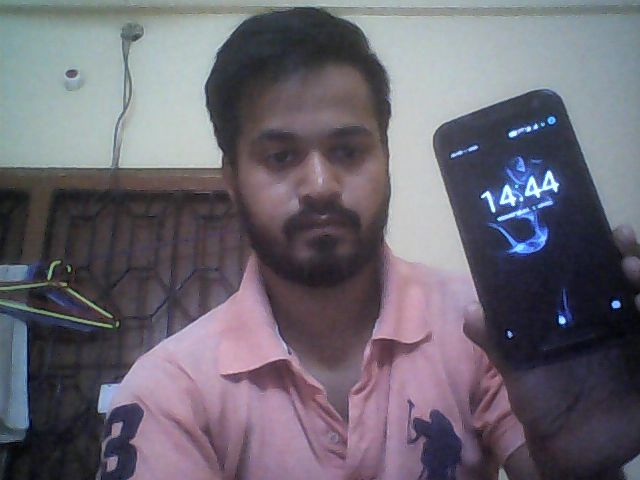

In [19]:

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [0]:
#Moving the captured photo i.e photo.jpg from /content/models/research/ to the directory of test_images i.e /content/models/research/object_detection/test_images/ 
!bash -c 'mv photo.jpg object_detection/test_images'

(480, 640, 3)


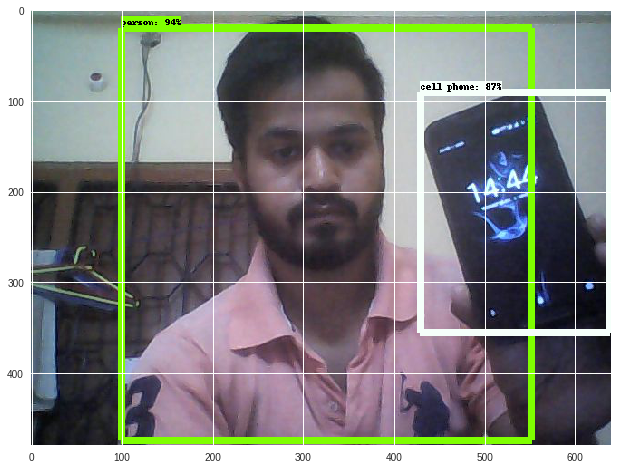

In [22]:
#Object detection for my image
%matplotlib inline
from PIL import Image
PATH_TO_TEST_IMAGES_DIR = 'object_detection/test_images'
my_image_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, 'photo.jpg') 
IMAGE_SIZE = (12, 8)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
            image = Image.open(my_image_path)
            image_np = load_image_into_numpy_array(image)
            image_process = detect_objects(image_np, sess, detection_graph)
            print(image_process.shape)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_process)
            plt.show()

In [26]:
  #Trying object detection on real-time video
from google.colab.patches import cv2_imshow
from imutils.video import FPS
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    cap=cv2.VideoCapture(0)
    time.sleep(2.0)
    fps=FPS().start()
    while(True):
      ret,frame=cap.read()
      print(ret)
      if not ret:
        break
      image_np = load_image_into_numpy_array(frame)  
      process_img=detect_objects(image_np,sess,detection_graph)
      cv2_imshow(process_image)
      key=cv2.waitKey(1) & 0xFF
      if key==ord('q'):
        break
      fps.update()
      
    fps.stop()
    print("Elapsed time:{:.2f}".format(fps.elapsed()))
    print("Approx FPS :{:.2f}".format(fps.fps()))
    cap.release()
    cv2.destroyAllWindows() 

False
Elapsed time:0.01
Approx FPS :0.00
